<a href="https://colab.research.google.com/github/hillsonghimire/EO-training-resources/blob/main/Topographic_Wetness_Index_(TWI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==========================================
#  Title:  Sentinel-1 based image thresholding to delienate water bodies
#  Author: hillson ghimire
#  Date:   Dec 2024
# ==========================================

In [ ]:
# !pip install geemap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ee
import geemap
import ipywidgets as widgets

ee.Authenticate()

In [ ]:
ee.Initialize(project='<your-project-id')

#### Visualization Parameter

In [ ]:
# Map visualisation parameters
zoom = 8
width="40%"
center = [25.18,62.32]

## 1. Select Area of Interest(AOI)

In [ ]:
# Select Area of Interest (AOI) using 'Draw a Rectangle' tool, the first drawn shape will become AOI
print("Select AOI using 'Draw a Rectangle' tool")
Map = geemap.Map(center = center, zoom = zoom,  width=width)
feature = Map.draw_features
Map

Select AOI using 'Draw a Rectangle' tool


Map(center=[25.18, 62.32], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
features = []
for element in (Map.draw_control.data):
  new_dict = {key: value for key, value in element.items() if key == 'geometry'}
  features.append(new_dict)


aoi = ee.Geometry.Polygon(features[0]['geometry']['coordinates'], None, False)
display(aoi)

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              62.650884,
              25.90883
            ],
            [
              62.650884,
              26.071771
            ],
            [
              62.882954,
              26.071771
            ],
            [
              62.882954,
              25.90883
            ],
            [
              62.650884,
              25.90883
            ]
          ]
        ]
      },
      "geodesic": {
        "constantValue": false
      }
    }
  }
})

## 2. Load Sentinel-1 SAR collection and filter to our region


A major limitation of visible satellite imagery is the presence of clouds. it is very difficult to create a visible timeseries of the earth surface. SAR sensors, like Sentinel-1, use radar waves, which penetrate clouds, allowing us to get a view of the earth surface, even when clouds are present. SAR works by sending a radar signal from the satellite towards the earth at an off nadir angle (i.e. not straight down, but at an angle). The signal hits the earth and scatters and the satellite measures how much backscatter returns to the satellite. The amount of backscatter is determined in part by the roughness of the surface, with smoother surfaces scattering less. Large flat surfaces like water scatter very little and stand out as dark spots against relatively high scattering land surface.

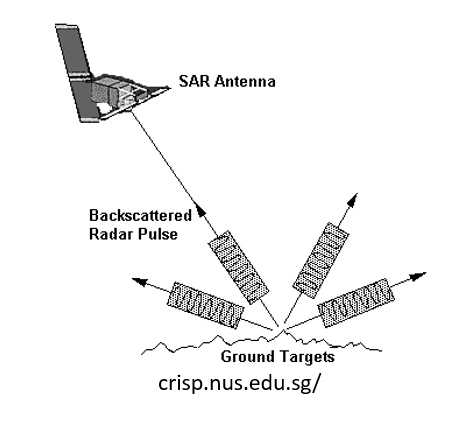


In [ ]:
# Load Sentinel-1 SAR collection and filter according to data collection type
S1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
  .filterBounds(aoi) \
  .filterDate('2017-01-01','2019-04-01') \
  .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
  .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'));


# Add first image to map to get an idea of what a SAR image looks like
viz_param = {'min': -18, 'max': 0, 'bands': 'VV'}

Map = geemap.Map(center = center, zoom = zoom,  width=width)
Map.addLayer(S1.first(), viz_param, name="Sentinel 1 Collection")
Map

Map(center=[25.18, 62.32], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

## 3. Speckel Filter

Speckle noise degrades SAR image quality. Speckel noise are the tiny bright pixels or dots in the SAR imagery. It is very difficult to classify the image while it has speckels.

There are a number of different techniques for dealing with speckles. We are going to use a very simple method, apply a **focal median filter**. This filter looks at each pixel and its **neighboring pixels and takes the median**. We then map this focal median process across all images in the collection.

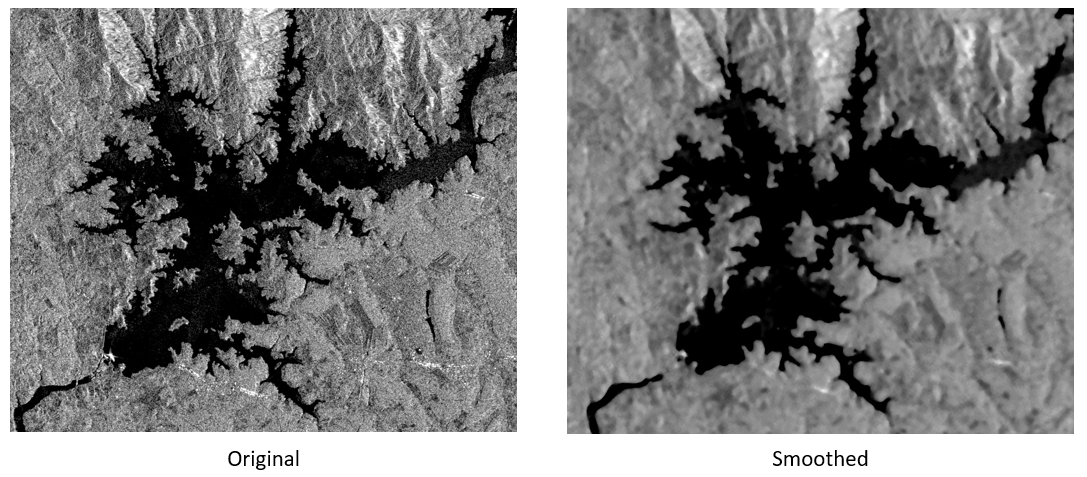

In [ ]:
# Filter speckle noise

def filterSpeckles(img):
  vv = img.select('VV') # select the VV polarization band
  vv_smoothed = vv.focal_median(100,'circle','meters').rename('VV_Filtered') # Apply a focal median filter
  return img.addBands(vv_smoothed) # Add filtered VV band to original image


# Map speckle noise filter across collection. Result is same collection, with smoothed VV band added to each image
S1 = S1.map(filterSpeckles)

# Add speckle filtered image to map to compare with raw SAR image
viz_param_Flt = {'min': -18, 'max': 0, 'bands': 'VV_Filtered'}

Map = geemap.Map(center = center, zoom = zoom,  width=width)
Map.addLayer(S1.first(),viz_param_Flt, 'Filtered SAR image')
Map

Map(center=[25.18, 62.32], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

**VV and VH in SAR Imagery, what are they?**

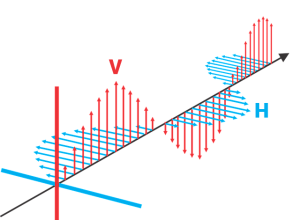

## 4. Classify Water Area

We'll use simple thresholding to identify water.

In SAR imagery, water appears darker than land, hence we'll pick a threshold of backscatter and classify all pixels below that threshold as water.

In this example we'll use  **-16 as threshold** to estimate water area. This threshold is simply based on guess, try adjusting the threshold if classification isn't very accurate.

In [ ]:
# This is only an approximation and will result in some errors.

def classifyWater(img):
  vv = img.select('VV_Filtered')
  water = vv.lt(-16).rename('Water')  # Identify all pixels below threshold and set them equal to 1. All other pixels set to 0
  water = water.updateMask(water) # Remove all pixels equal to 0
  return img.addBands(water)  # Return image with added classified water band


# Map classificati5on across sentinel-1 collection and print to console to inspect
S1 = S1.map(classifyWater)
display(S1)

In [ ]:
Map = geemap.Map(center = center, zoom = zoom,  width=width)
visParams = {'min': 0, 'max': 1, 'palette': ['#FFFFFF','#0000FF']}
Map.addLayer(S1.select('Water'), visParams)
Map

Map(center=[25.18, 62.32], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…